# Analyses and Figures

In [ ]:
import numpy as np
import pandas as pd
from math import ceil
import scipy.stats as scs
from statsmodels.stats.descriptivestats import sign_test

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import seaborn as sns

In [ ]:
import os
import hypervolumes as hv

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
fpath_out = "/work/users/mtorrassa/biofire-idh/data"

In [4]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.5, rc={"lines.linewidth": 2})
# mpl.rcParams.update({'font.size': 30})

## Realizing the plots

### Hypervolume representation (Fig. S2)

In [5]:
Cmin, Cmax = 0.0, 0.3
Mmin, Mmax = 0.0, 0.09
Lmin, Lmax = 0.002, 0.5

In [65]:
biome, N ='med', 50

df2 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df2[(df2['N']==N)&(df2['biome']==biome) & (df2['srichness']>5)].sort_values('frichness')

,Unnamed: 0,biome,N,ncom,init,frt,srichness,isimpson,frichness,fdivergence
86237,86237,med,50,736,18,312.500000,6,2.335600,0.000019,0.123683
86253,86253,med,50,736,34,263.157898,7,2.358557,0.000019,0.129520
55207,55207,med,50,139,32,68.493149,6,2.873017,0.000027,0.121316
86259,86259,med,50,736,40,238.095245,6,2.386727,0.000029,0.132045
86266,86266,med,50,736,47,333.333344,6,2.441202,0.000030,0.138876
...,...,...,...,...,...,...,...,...,...,...
63517,63517,med,50,299,22,14.749263,7,5.015234,0.052259,0.520581
63518,63518,med,50,299,23,14.619883,7,4.919671,0.052426,0.529600
63536,63536,med,50,299,41,15.060241,7,4.922701,0.052705,0.532610
64928,64928,med,50,326,29,21.551724,6,4.026817,0.056811,0.595018


bandwidths: [0.14123685 0.09307964 0.05814203 0.15505691 0.11121955]
sample: 284


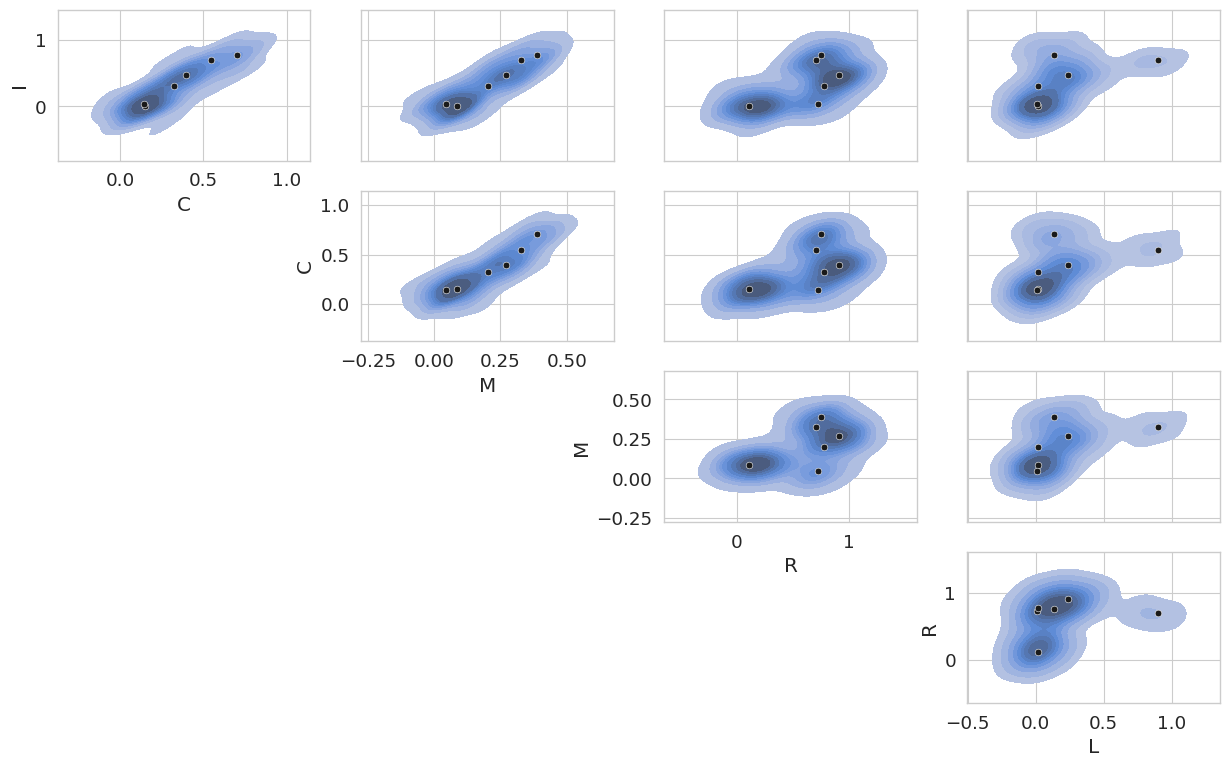

In [ ]:
df = df2[(df2['N']==N)&(df2['biome']==biome)&(df2['ncom']==326)&(df2['init']==12)]
df_temp = pd.DataFrame(index=['I','C','R','L']).T

NP = df['N'].values[0]
i_com = df['ncom'].values[0]
init = df['init'].values[0]

df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{NP}/coms-n{NP}-{biome}-{i_com}-{init}.csv'))

# range transformation
df['I'] = (df['I'] - 1) / (NP-1)
df['C'] = (df['C'] - Cmin) / (Cmax - Cmin)
df['M'] = (df['M'] - Mmin) / (Mmax - Mmin)
df['L'] = (df['L'] - Lmin) / (Lmax - Lmin)

np_temp = df.to_numpy()[:,1:]
hv_temp = hv.hypervolume(np_temp, verbose=True)
df_hv = pd.DataFrame(hv_temp, columns=['I','C','M','R','L'])

df_sng = df.drop_duplicates()

fig, axs = plt.subplots(4, 4, figsize=(15, 9))
# fig.suptitle(f"Hypervolumes | Alternative states of N={NP} ncom={i_com}")

trait_list = ['I','C','M','R','L']
for i,y in enumerate(trait_list):
    for j,x in enumerate(trait_list[i+1:]):
        if x != y:
            sns.kdeplot(data=df_hv, x=x, y=y, warn_singular=False, ax=axs[i,j+i], fill=True)
            sns.scatterplot(data=df_sng, x=x, y=y, ax=axs[i,j+i], c='k')
        if j!=0:
            axs[i,j+i].label_outer()
        if i!=0:
            axs[j+i,i-1].remove()

# plt.tight_layout(h_pad=0.00001, w_pad=0.00001)

In [121]:
df = pd.read_csv(os.path.join(fpath_out,f'comp_{biome}{NP}/coms-n{NP}-{biome}-{i_com}-{init}.csv'))
df.value_counts()

Unnamed: 0  I     C        M        R        L      
1           1.0   0.04602  0.00784  0.11216  0.01033    216
24          24.0  0.11958  0.02424  0.91484  0.12184    142
3           3.0   0.04415  0.00400  0.72381  0.00789    109
39          39.0  0.21108  0.03502  0.75534  0.07103     82
35          35.0  0.16370  0.02939  0.70436  0.45020     50
16          16.0  0.09663  0.01818  0.77738  0.01171      8
Name: count, dtype: int64

### Biodiversity in Fire model vs Tilman (Fig. 1)

In [6]:
df_diff = pd.read_csv(os.path.join(fpath_out, 'biodindex-difference.csv'))
df_diff.loc[df_diff['eco-type']=='med10','eco-type'] = 'Med-10'
df_diff.loc[df_diff['eco-type']=='med50','eco-type'] = 'Med-50'
df_diff.loc[df_diff['eco-type']=='bor10','eco-type'] = 'Bor-10'

##### Wilcoxon signed-rank test
The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

In [7]:
for bioind in ['isimpson', 'frichness', 'fdivergence']:

    print(bioind)
    for biome in ['Med-10', 'Med-50', 'Bor-10']:

        arrdat = df_diff[df_diff['eco-type']==biome][bioind].to_numpy()

        stat, pvalue = scs.wilcoxon(x=arrdat, alternative='less', zero_method='wilcox')
        
        print(biome)
        print('statistic:', '{:.0f}'.format(stat), '\npvalue:', '{:.4f}'.format(pvalue), '\n', pvalue<0.05, '\n')
    print('\n')

isimpson
Med-10
statistic: 83831851 
pvalue: 1.0000 
 False 

Med-50
statistic: 557311739 
pvalue: 1.0000 
 False 

Bor-10
statistic: 99464068 
pvalue: 1.0000 
 False 



frichness
Med-10
statistic: 67349085 
pvalue: 0.0000 
 True 

Med-50
statistic: 353690524 
pvalue: 0.0000 
 True 

Bor-10
statistic: 64329307 
pvalue: 1.0000 
 False 



fdivergence
Med-10
statistic: 97981271 
pvalue: 1.0000 
 False 

Med-50
statistic: 588853075 
pvalue: 1.0000 
 False 

Bor-10
statistic: 101754177 
pvalue: 1.0000 
 False 





In [12]:
# np.random.seed(0)
# print('MWU test -- H_A: observed data is greater than zero distribution')
# for bioind in ['srichness', 'isimpson', 'frichness', 'fdivergence']:

#     print(bioind)
#     for biome in ['Med-10', 'Med-50', 'Bor-10']:

#         arrdat = df_diff[df_diff['eco-type']==biome][bioind].to_numpy()
#         if bioind=='srichness':
#             zerodist = np.random.normal(loc=0, scale=np.std(arrdat), size=arrdat.shape).astype(int)
#         else:
#             zerodist = np.random.normal(loc=0, scale=np.std(arrdat), size=arrdat.shape)

#         stat, pvalue = scs.mannwhitneyu(arrdat, zerodist, alternative='greater')
        
#         print(biome)
#         print('statistic:', '{:.0f}'.format(stat), '\npvalue:', '{:.4f}'.format(pvalue), '\n', pvalue<0.05, '\n')
#     print('\n')

##### Sign Test
Applied to the discrete distribution of $\Delta S$

In [33]:
ntot = len(df_diff['eco-type']=='Med-50')
nnull = len(df_diff[(df_diff['srichness']==0) & (df_diff['eco-type']=='Med-50')])
npos = len(df_diff[(df_diff['srichness']>0) & (df_diff['eco-type']=='Med-50')])
nneg = len(df_diff[(df_diff['srichness']<0) & (df_diff['eco-type']=='Med-50')])
print(ntot, nnull, npos, nneg)
print(ntot, nnull/ntot, npos/ntot, nneg/ntot)

100000 18677 19441 13882
100000 0.18677 0.19441 0.13882


In [ ]:
ntot = len(df_diff['eco-type']=='Med-10')
nnull = len(df_diff[(df_diff['srichness']==0) & (df_diff['eco-type']=='Med-10')])
npos = len(df_diff[(df_diff['srichness']>0) & (df_diff['eco-type']=='Med-10')])
nneg = len(df_diff[(df_diff['srichness']<0) & (df_diff['eco-type']=='Med-10')])
print(ntot, nnull, npos, nneg)
print(ntot, nnull/ntot, npos/ntot, nneg/ntot)

100000 10435 7393 6172
100000 0.10435 0.07393 0.06172


In [32]:
ntot = len(df_diff['eco-type']=='Bor-10')
nnull = len(df_diff[(df_diff['srichness']==0) & (df_diff['eco-type']=='Bor-10')])
npos = len(df_diff[(df_diff['srichness']>0) & (df_diff['eco-type']=='Bor-10')])
nneg = len(df_diff[(df_diff['srichness']<0) & (df_diff['eco-type']=='Bor-10')])
print(ntot, nnull, npos, nneg)
print(ntot, nnull/ntot, npos/ntot, nneg/ntot)

100000 11800 9712 2488
100000 0.118 0.09712 0.02488


In [8]:
for bioind in ['srichness']:

    print(bioind)
    for biome in ['Med-10', 'Med-50', 'Bor-10']:

        arrdat = df_diff[df_diff['eco-type']==biome][bioind].to_numpy()

        M, pvalue = sign_test(samp=arrdat, mu0=0)
        
        print(biome)
        print('M:', '{:.0f}'.format(M), '\npvalue:', '{:.4f}'.format(pvalue), '\n', pvalue<0.05, M>0, '\n')
    print('\n')

srichness
Med-10
M: 610 
pvalue: 0.0000 
 True True 

Med-50
M: 2780 
pvalue: 0.0000 
 True True 

Bor-10
M: 3612 
pvalue: 0.0000 
 True True 





##### T-Test
Applied to the discrete distribution of $\Delta S$

In [9]:
for bioind in ['srichness']:

    print(bioind)
    for biome in ['Med-10', 'Med-50', 'Bor-10']:

        arrdat = df_diff[df_diff['eco-type']==biome][bioind].to_numpy()

        stat, pvalue = scs.ttest_1samp(a=arrdat, popmean=0, alternative='greater')
        
        print(biome)
        print('Stat:', '{:.0f}'.format(stat), '\npvalue:', '{:.4f}'.format(pvalue), '\n', pvalue<0.05, '\n')
    print('\n')

srichness
Med-10
Stat: 12 
pvalue: 0.0000 
 True 

Med-50
Stat: 35 
pvalue: 0.0000 
 True 

Bor-10
Stat: 70 
pvalue: 0.0000 
 True 





#### Plot the distributions

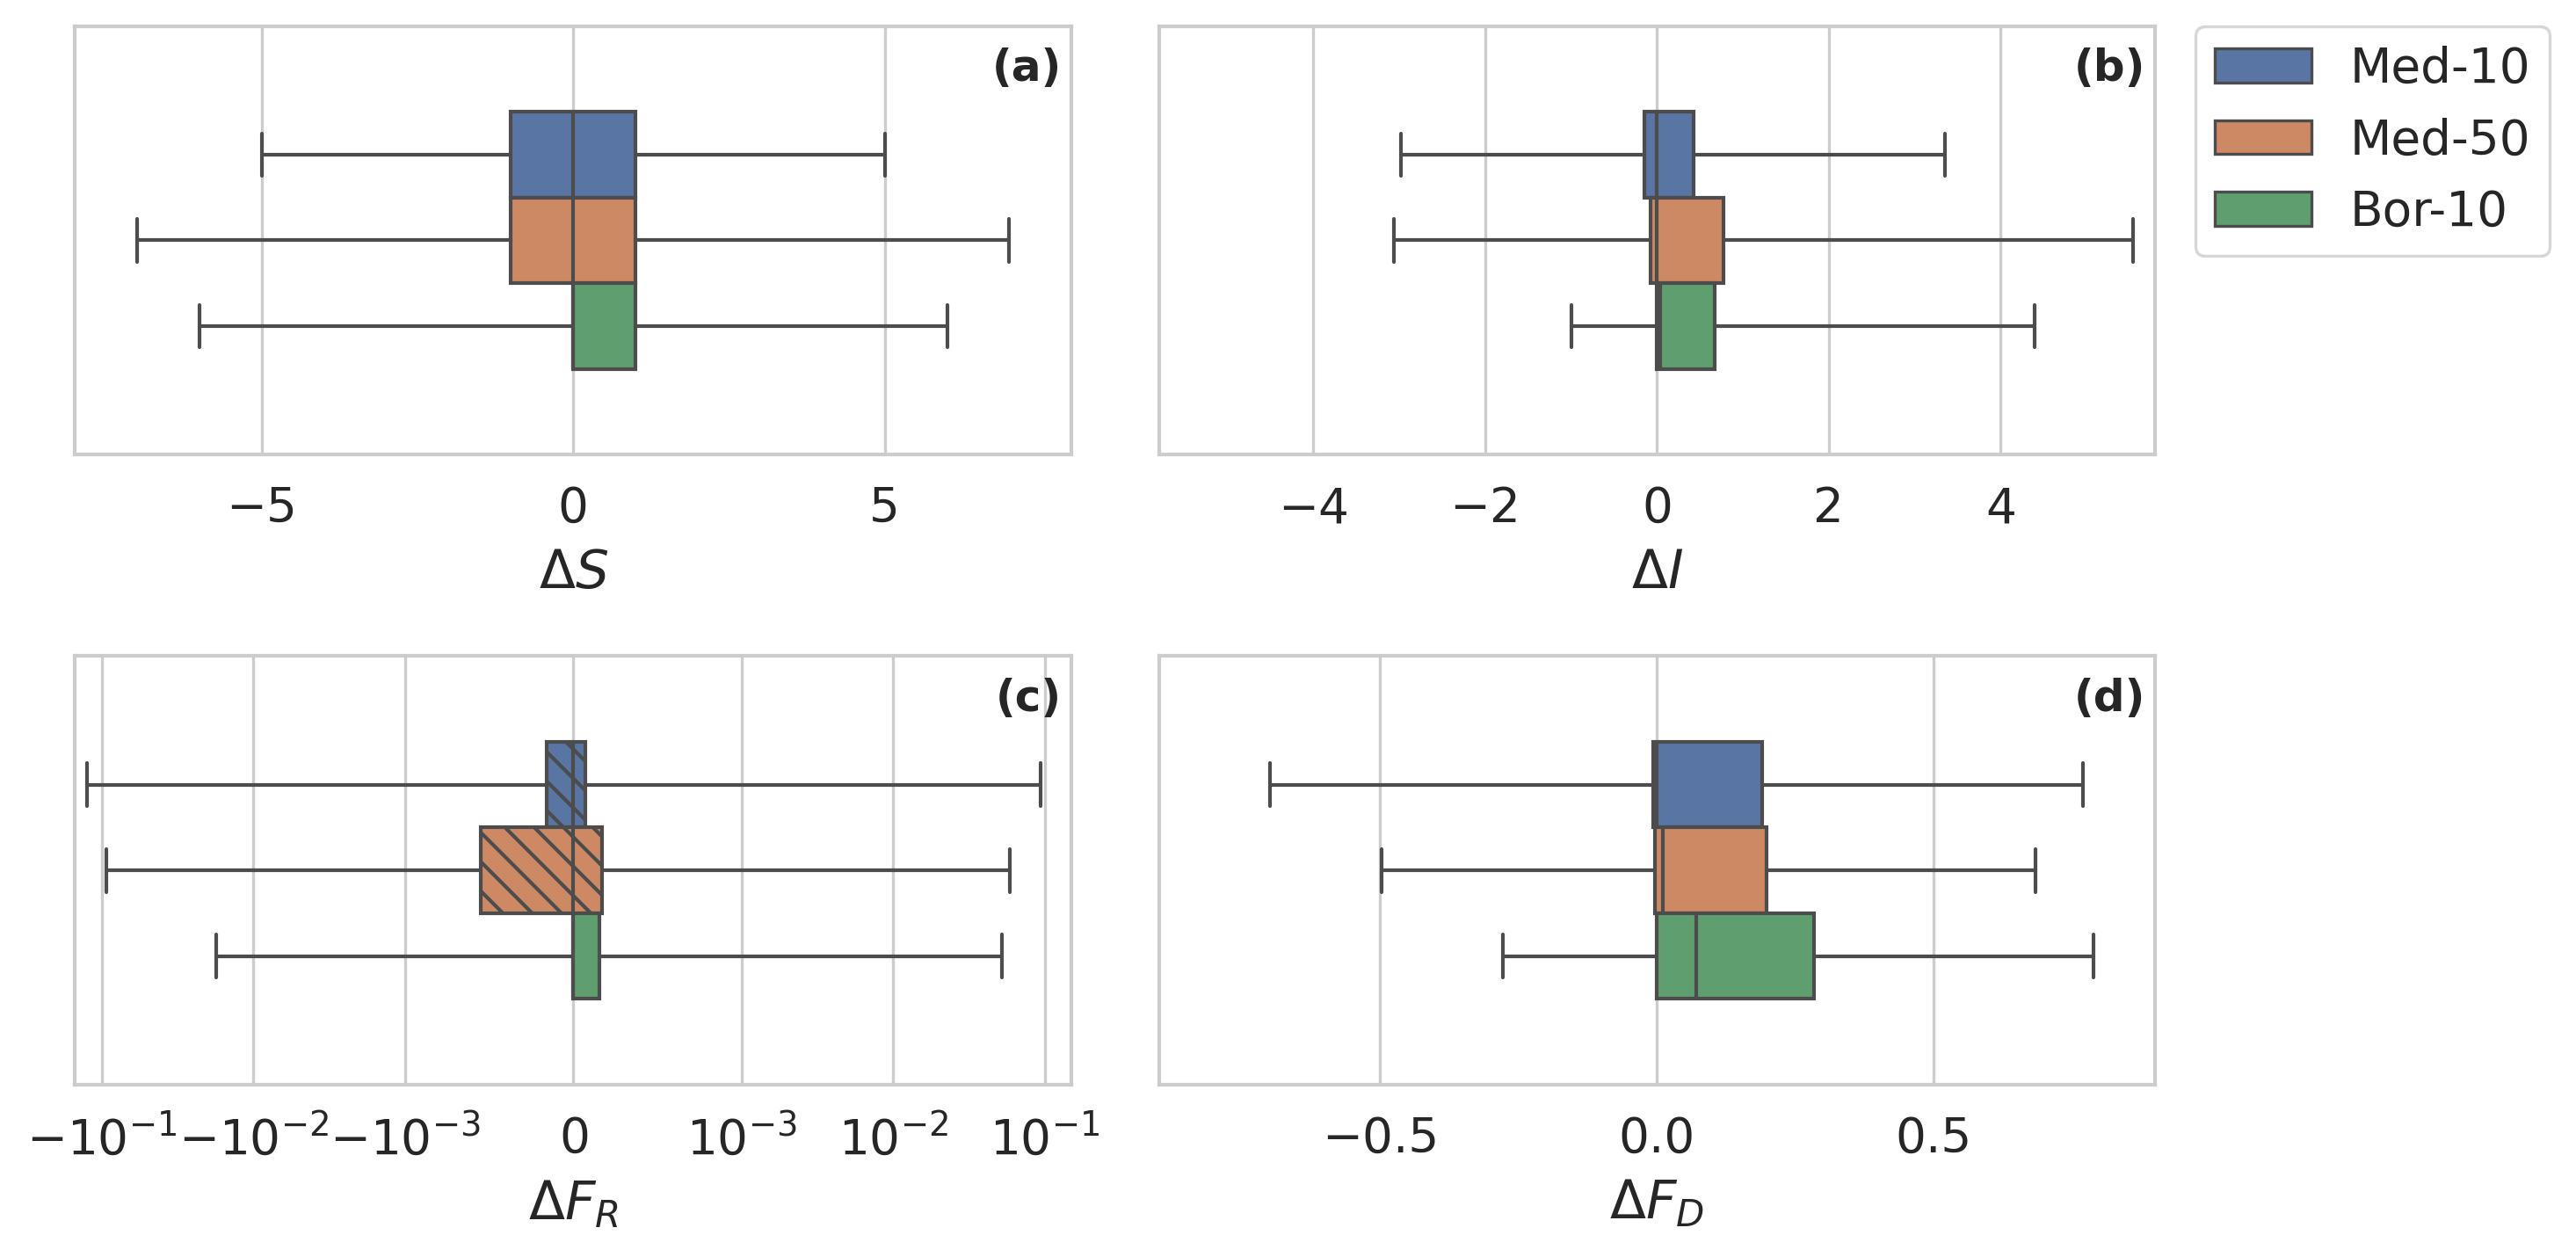

In [6]:
fig, ax2 = plt.subplots(2,2, figsize=(10,5), sharey=True, dpi=300)

data = df_diff

hue_order = ['Med-10', 'Med-50', 'Bor-10']

sns.boxplot(data=data, x="srichness", hue='eco-type', hue_order=hue_order, width=.6, whis=1000, ax=ax2[0,0], legend=False)
# sns.boxplot(data=data, x="srichness", hue='eco-type', hue_order=hue_order, width=.6, ax=ax2[0,0], legend=False)
ax2[0,0].set_xlabel(r'$\Delta S$')
ax2[0,0].set_xlim(-8, 8)
# ax2[0,0].set_xticks(np.arange(-4, 9, 2))

sns.boxplot(data=data, x="isimpson", hue='eco-type', hue_order=hue_order, width=.6, whis=1000, ax=ax2[0,1])
ax2[0,1].set_xlabel(r'$\Delta I$')
ax2[0,1].set_xlim(-5.8, 5.8)

box = sns.boxplot(data=data, x="frichness", hue='eco-type', hue_order=hue_order, width=.6, whis=3000, ax=ax2[1,0], legend=False)
# Define some hatches
hatches = ['\\\\\\', '\\\\\\', '']
# Loop over the bars
for i,thisbar in enumerate(box.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
# sns.boxplot(data=data, x="frichness", hue='eco-type', width=.6, ax=ax2[1,0], legend=False)
ax2[1,0].set_xlabel(r'$\Delta F_R$')
ax2[1,0].set_xscale('symlog', linthresh=0.001)
ax2[1,0].set_xlim(-0.15, 0.15)
# ax2[1,0].set_xticks([-0.1, -0.01, -0.001, 0.0, 0.001, 0.01, 0.1])

sns.boxplot(data=data, x="fdivergence", hue='eco-type', hue_order=hue_order, width=.6, whis=1000, ax=ax2[1,1], legend=False)
ax2[1,1].set_xlabel(r'$\Delta F_D$')
ax2[1,1].set_xlim(-0.9, 0.9)

# Add identifying letters to each subplot, positioned at the top-right corner
letters = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(ax2.flat):
    ax.text(0.99, 0.95, letters[i], transform=ax.transAxes, fontsize=12, fontweight='bold', 
            va='top', ha='right')

ax2[0,1].legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()

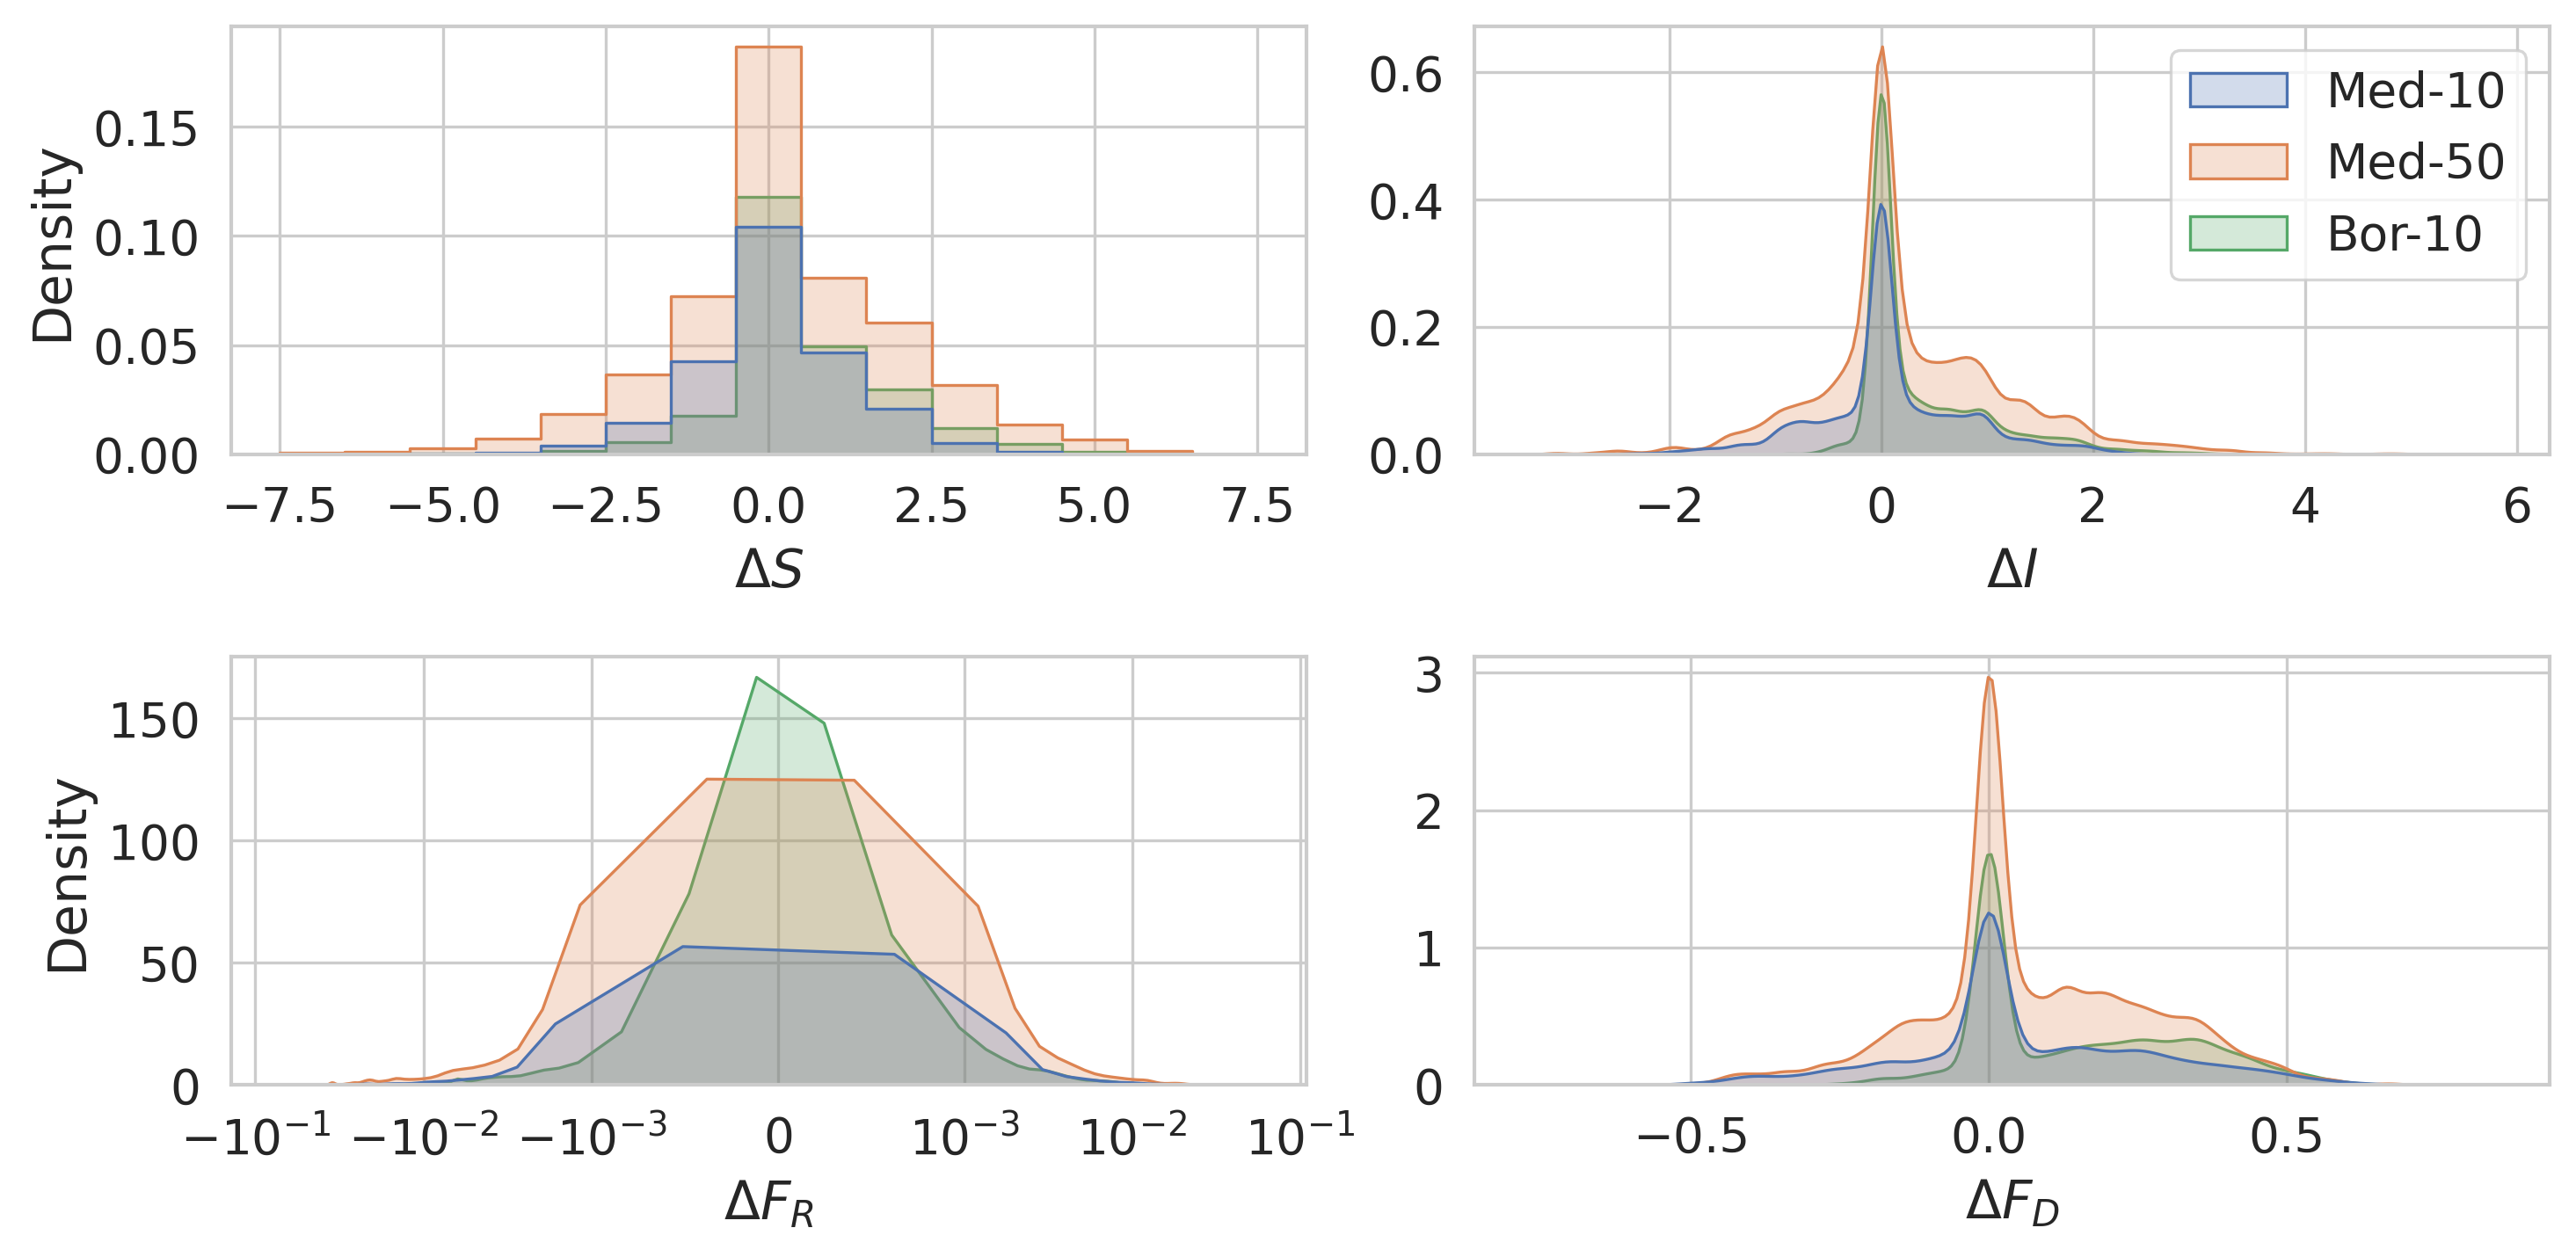

In [7]:
fig, ax2 = plt.subplots(2,2, figsize=(10,5), dpi=300)

data = df_diff

sns.histplot(data=data, x="srichness", hue='eco-type', hue_order=hue_order, stat='density', element="step", binwidth=1, binrange=(min(data['srichness'])-0.5, max(data['srichness']) + 0.5), ax=ax2[0,0], legend=False)
ax2[0,0].set_xlabel(r'$\Delta S$')

sns.kdeplot(data=data, x="isimpson", hue='eco-type', hue_order=hue_order, fill=True, ax=ax2[0,1])
ax2[0,1].set_xlabel(r'$\Delta I$')

sns.kdeplot(data=data, x="frichness", hue='eco-type', hue_order=hue_order, fill=True, ax=ax2[1,0], legend=False)
ax2[1,0].set_xlabel(r'$\Delta F_R$')
ax2[1,0].set_xscale('symlog', linthresh=0.001)
ax2[1,0].set_xticks([-0.1, -0.01, -0.001, 0.0, 0.001, 0.01, 0.1])

sns.kdeplot(data=data, x="fdivergence", hue='eco-type', hue_order=hue_order, fill=True, ax=ax2[1,1], legend=False)
ax2[1,1].set_xlabel(r'$\Delta F_D$')

for ax in ax2[:,1]:
    ax.set_ylabel("")
    # ax.label_outer()
    # ax.set_xlabel('')
    # ax.set_xticks([0, 1, 2])
    # ax.set_xticklabels(['Med-10', 'Med-50', 'Bor-10'])

ax2[0,1].get_legend().set_title("")
# sns.move_legend(ax2[0,1], "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

### Biodiversity over fire return time gradient

####  Quantile Regression
Quantile Regression libraries and functions

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

max_iter = 350000

In [ ]:
def wald_test(model):

# Get the coefficients (excluding intercept)
    beta = model.params[1:]  # Coefficients for X and X_squared

    # Get the covariance matrix of the estimated coefficients
    cov_matrix = model.cov_params().iloc[1:, 1:]  # Covariance for X and X_squared

    # Wald statistic calculation: W = beta' * (cov^-1) * beta
    wald_stat = np.dot(np.dot(beta.T, np.linalg.inv(cov_matrix)), beta)

    # Degrees of freedom is the number of coefficients (excluding the intercept)
    df = len(beta)

    # Compute p-value based on chi-squared distribution
    p_value = scs.chi2.sf(wald_stat, df)

    # print(f"Wald Test Statistic: {wald_stat:.4f}")
    # print(f"p-value: {p_value:.4f}")

    return wald_stat, p_value

In [ ]:
def aic_test(Y, X, Y_pr, model):
    # return aic metric
    k_params = model.df_model + model.k_constant
    
    # Estimate maximized log likelihood
    nobs = float(X.shape[0])
    nobs2 = nobs / 2.0
    nobs = float(nobs)
    resid = Y - Y_pr
    ssr = np.sum((resid)**2)
    llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2

    return -2 * llf + 2 * k_params

In [ ]:
def best_poly_quantile_regression(Y, X, quantile=0.5, max_degree=5, verbose=True):
    best_degree = None
    best_aic = np.inf  # Initialize to a large value
    best_model = None

    # Data preparation
    data = pd.DataFrame({'X': X, 'Y': Y})

    # Iterate over polynomial degrees from 1 to max_degree
    for degree in range(1, max_degree + 1):
        # Construct formula for polynomial regression up to the current degree
        formula = 'Y ~ ' + ' + '.join([f'np.power(X, {i})' for i in range(1, degree + 1)])

        # Fit quantile regression for the current degree
        model = smf.quantreg(formula, data).fit(q=quantile, max_iter=max_iter)
        
        # Predict the values for Y
        Y_pr = model.predict(data)
        
        # Calculate AIC for the current model
        aic_value = aic_test(data['Y'], data['X'], Y_pr, model)
        
        # print(f'Degree {degree}: AIC = {aic_value:.4f}')

        w_stat, w_pval = wald_test(model)
        # keep only the statistically significant regression
        if w_pval < 0.05:
            # Update the best model if current AIC is smaller
            if aic_value < best_aic:
                best_aic = aic_value
                best_degree = degree
                best_model = model

    if verbose:
        print(f'Best Polynomial Degree: {best_degree} with AIC = {best_aic:.4f}\n')
    return best_degree, best_model, best_aic

In [5]:
# Common parameters for the plots
sz = 10
al = 0.3

frt_max = 1800
frt_min = 4

colorq = ['crimson','gold','cornflowerblue'] #['purple', 'darkorange', 'forestgreen']
quantiles = [.95, .85, .75]

In [6]:
df2 = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df2['frt']=np.log10(df2['frt'])

In [9]:
n=50
i = 1
biome='med'
data = df2[(df2['N'] == n) & (df2['biome'] == biome)]
data['srichness'].max(), data['isimpson'].max(), data['frichness'].max(), data['fdivergence'].max()

(9, 6.77757229082745, 0.0583591466313013, 0.6839465706080549)

#### Compositional Diversity ($S$, $I$) with Quantile Regression

In [21]:
def plot_qreg_cdiv(df, ax2, i, n, biome, quantiles=[.75, .85, .95], colorq=['crimson','gold','cornflowerblue'], orientation='v', verbose=True):

    if orientation=='v':
        ax2[1,0].set_ylabel("Species Richness, $S$")
        ax2[1,1].set_ylabel("Inverse Simpson Index, $I$")
    elif orientation=='o':
        ax2[0,0].set_ylabel("Species Richness, $S$")
        ax2[1,0].set_ylabel("Inverse Simpson Index, $I$")

    if verbose:
        print(f'n={n}, {biome}')

    if np.any(df):

        data = df[(df['N'] == n) & (df['biome'] == biome)]

        if orientation=='v':
            ax2[i,0].scatter('frt', 'srichness', data=data, s=sz, alpha=al, c='grey', label='')
            ax2[i,1].scatter('frt', 'isimpson', data=data, s=sz, alpha=al, c='grey', label='')
            
        elif orientation=='o':
            ax2[0,i].scatter('frt', 'srichness', data=data, s=sz, alpha=al, c='grey', label='')
            ax2[1,i].scatter('frt', 'isimpson', data=data, s=sz, alpha=al, c='grey', label='')



        # QUANTILE REGRESSION

        x_p = np.linspace(data.frt.min(), data.frt.max(), 100)

        for q,cq in zip(quantiles,colorq):
            if verbose:
                print(f'Quantile={q}')
            X = data['frt']
            Y = data['srichness']
            best_degree, best_model, best_aic = best_poly_quantile_regression(Y, X, quantile=q, max_degree=5, verbose=verbose)
            df_pred = pd.DataFrame({'X': x_p})
            # Add the necessary polynomial terms up to the best degree found
            for degree in range(2, best_degree + 1):
                df_pred[f'np.power(X, {degree})'] = np.power(df_pred['X'], degree)

            if orientation=='v':
                ax2[i,0].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))
            elif orientation=='o':
                ax2[0,i].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))

            if verbose:
                print('Inverse Simpson Index')
            Y = data['isimpson']
            best_degree, best_model, best_aic = best_poly_quantile_regression(Y, X, quantile=q, max_degree=5, verbose=verbose)
            df_pred = pd.DataFrame({'X': x_p})
            # Add the necessary polynomial terms up to the best degree found
            for degree in range(2, best_degree + 1):
                df_pred[f'np.power(X, {degree})'] = np.power(df_pred['X'], degree)
            
            if orientation=='v':
                ax2[i,1].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))
            elif orientation=='o':
                ax2[1,i].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))


n=10, med
Quantile=0.95
Best Polynomial Degree: 5 with AIC = 98596.6062

Inverse Simpson Index
Best Polynomial Degree: 5 with AIC = 77958.1413

Quantile=0.85
Best Polynomial Degree: 3 with AIC = 79349.6778

Inverse Simpson Index
Best Polynomial Degree: 2 with AIC = 58017.4532

Quantile=0.75
Best Polynomial Degree: 5 with AIC = 72258.5083

Inverse Simpson Index
Best Polynomial Degree: 3 with AIC = 46526.1811

n=50, med
Quantile=0.95
Best Polynomial Degree: 5 with AIC = 258743.0958

Inverse Simpson Index
Best Polynomial Degree: 4 with AIC = 199608.6200

Quantile=0.85
Best Polynomial Degree: 2 with AIC = 221169.9683

Inverse Simpson Index
Best Polynomial Degree: 5 with AIC = 159702.2440

Quantile=0.75
Best Polynomial Degree: 4 with AIC = 197622.1811

Inverse Simpson Index
Best Polynomial Degree: 3 with AIC = 136232.0359

n=10, bor
Quantile=0.95
Best Polynomial Degree: 5 with AIC = 108244.8940

Inverse Simpson Index
Best Polynomial Degree: 5 with AIC = 78213.7427

Quantile=0.85
Best Polyno

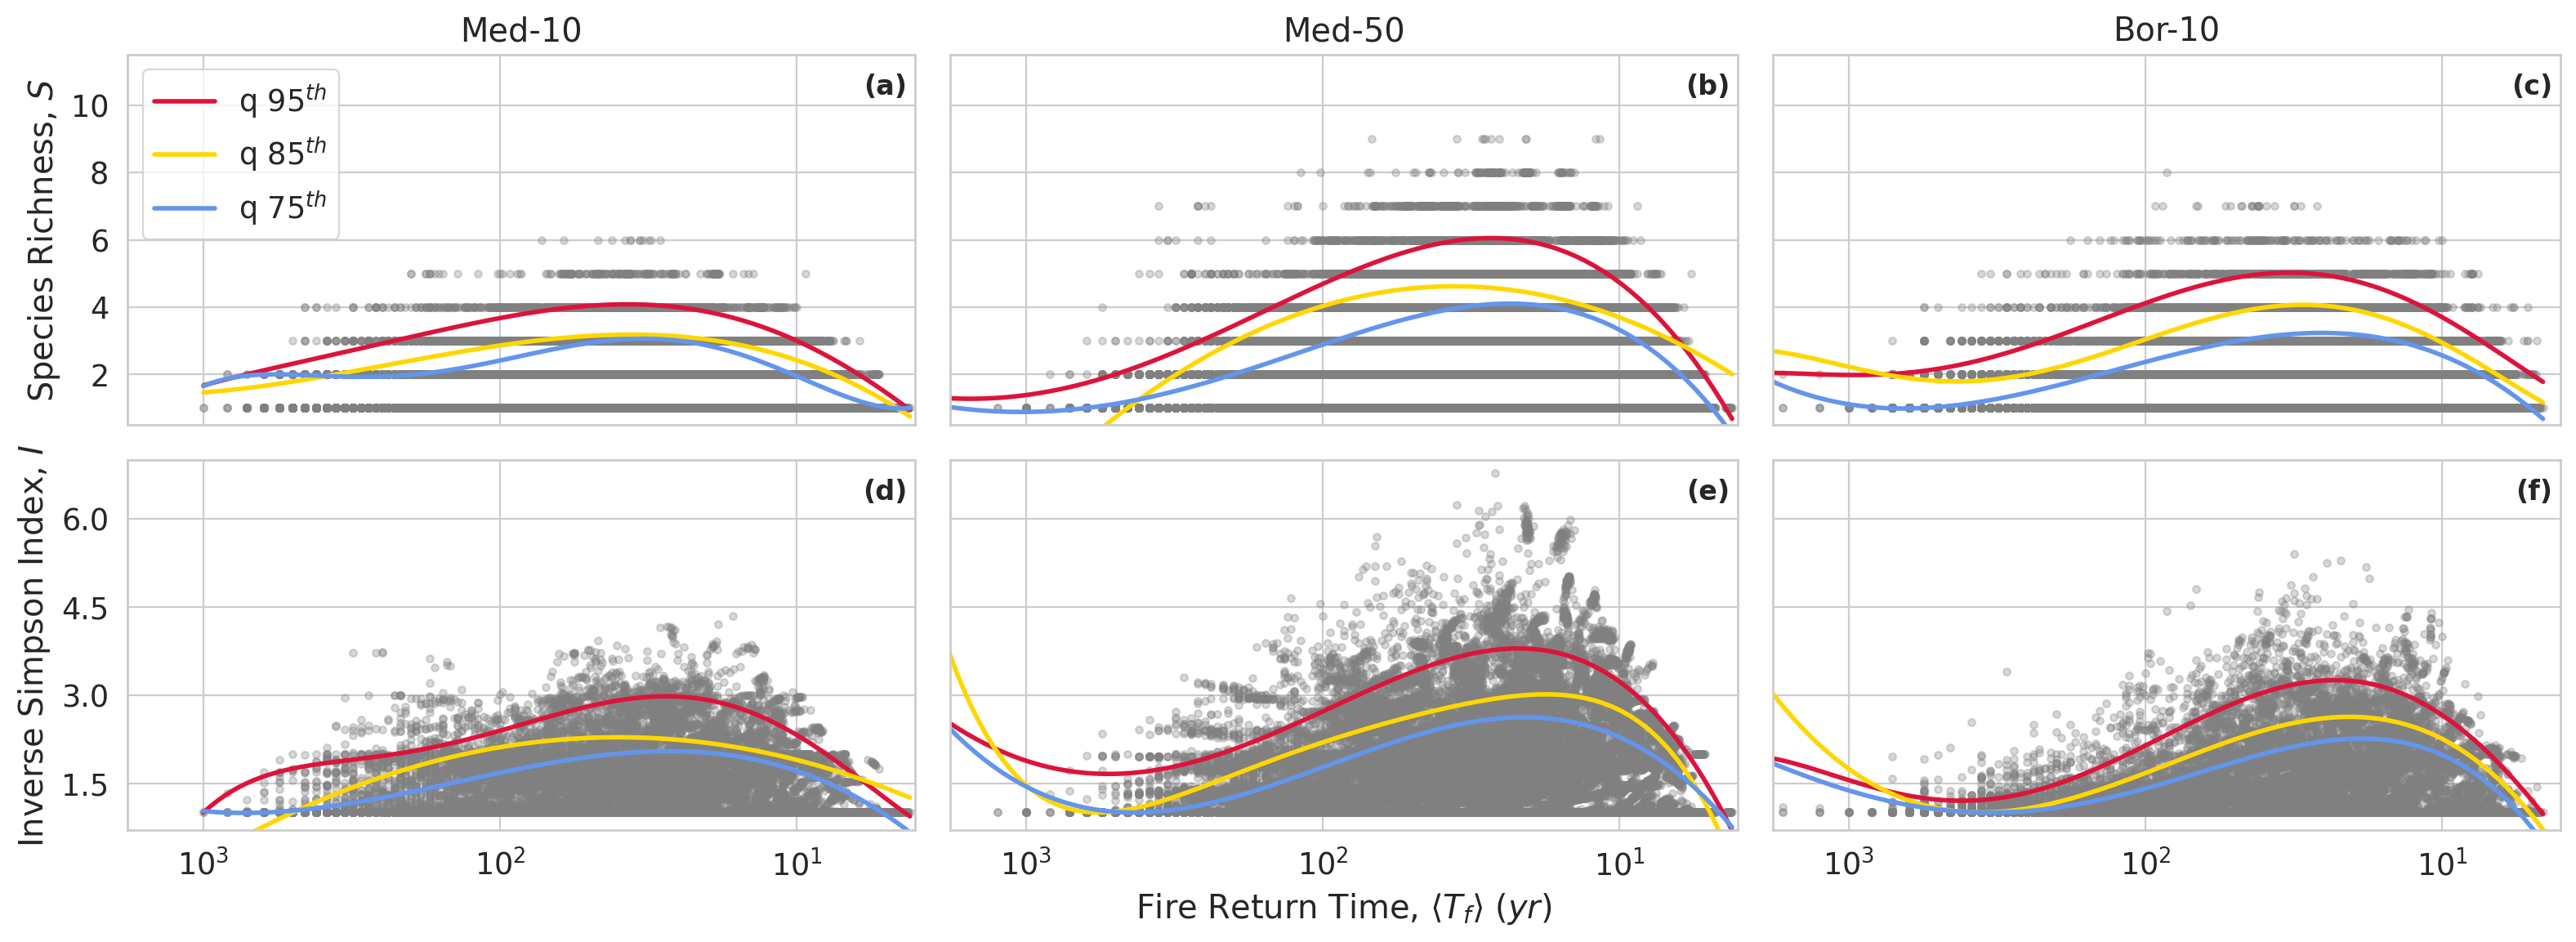

In [22]:
fig, ax2 = plt.subplots(2,3, figsize=(16,6), sharex=True, sharey='row', dpi=200)

n=10
i = 0
biome='med'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=True)

n=50
i = 1
biome='med'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=True)

n=10
i = 2
biome='bor'
plot_qreg_cdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=True)

# fix the aesthetic of the plot
# Add a single x-label at the bottom

ax2[1,1].set_xlabel(r"Fire Return Time, $\langle T_f \rangle$ ($yr$)")

axs = ax2.flatten()
for ax in axs:
    ax.invert_xaxis()
    ax.set(xlim=(np.log10(frt_max),np.log10(frt_min)))
    ticks = [1, 2, 3]
    ax.set_xticks(ticks)
    ax.set_xticklabels([fr'$10^{i}$' for i in ticks])

for ax in ax2[0]:
    ax.set_yticks(np.linspace(0, 10, 6))
    ax.set_ylim([0.5,11.5])

for ax in ax2[1]:
    ax.set_yticks(np.linspace(1.5, 6.0, 4))
    ax.set_ylim([0.7,7.0])

ax2[0,0].set_title('Med-10')
ax2[0,1].set_title('Med-50')
ax2[0,2].set_title('Bor-10')

# Add identifying letters to each subplot, positioned at the top-right corner
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(ax2.flat):
    ax.text(0.99, 0.95, letters[i], transform=ax.transAxes, fontsize=12, fontweight='bold', 
            va='top', ha='right')

# ax2[0,-1].legend(bbox_to_anchor=(1.15, 1), loc="upper left", borderaxespad=0)
ax2[0,0].legend()
plt.tight_layout()

#### Functional Diversity ($F_R$, $F_D$) with Quantile Regression

In [41]:
def plot_qreg_fdiv(df, ax2, i, n, biome, quantiles=[.95, .85, .75], colorq=['crimson','gold','cornflowerblue'], orientation='o', verbose=True):

    if orientation=='v':
        ax2[1,0].set_ylabel("Functional Richness, $F_R$")
        ax2[1,1].set_ylabel("Functional Divergence, $F_D$")
    elif orientation=='o':
        ax2[0,0].set_ylabel("Functional Richness, $F_R$")
        ax2[1,0].set_ylabel("Functional Divergence, $F_D$")
    

    if verbose:
        print(f'n={n}, {biome}')

    if np.any(df):

        data = df[(df['N'] == n) & (df['biome'] == biome)]
        
        if orientation=='v':
            ax2[i,0].scatter('frt', 'frichness', data=data, s=sz, alpha=al, c='grey', label='')
            ax2[i,1].scatter('frt', 'fdivergence', data=data, s=sz, alpha=al, c='grey', label='')
        elif orientation=='o':
            ax2[0,i].scatter('frt', 'frichness', data=data, s=sz, alpha=al, c='grey', label='')
            ax2[1,i].scatter('frt', 'fdivergence', data=data, s=sz, alpha=al, c='grey', label='')

        # QUANTILE REGRESSION

        x_p = np.linspace(data.frt.min(), data.frt.max(), 100)

        for q,cq in zip(quantiles,colorq):
            if verbose:
                print(f'Quantile={q}')

            X = data['frt']

            if verbose:
                print('Functional Richness')

            Y = data['frichness']
            best_degree, best_model, best_aic = best_poly_quantile_regression(Y, X, quantile=q, max_degree=5, verbose=verbose)
            df_pred = pd.DataFrame({'X': x_p})
            # Add the necessary polynomial terms up to the best degree found
            for degree in range(2, best_degree + 1):
                df_pred[f'np.power(X, {degree})'] = np.power(df_pred['X'], degree)
            if orientation=='v':
                ax2[i,0].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))
            elif orientation=='o':
                ax2[0,i].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))

            if verbose:
                print('Functional Divergence')

            Y = data['fdivergence']
            best_degree, best_model, best_aic = best_poly_quantile_regression(Y, X, quantile=q, max_degree=5, verbose=verbose)
            df_pred = pd.DataFrame({'X': x_p})
            # Add the necessary polynomial terms up to the best degree found
            for degree in range(2, best_degree + 1):
                df_pred[f'np.power(X, {degree})'] = np.power(df_pred['X'], degree)
            if orientation=='v':
                ax2[i,1].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))
            elif orientation=='o':
                ax2[1,i].plot(x_p, best_model.predict(df_pred), linestyle='-', color=cq, label='q {}{}'.format(int(q*100), r'$^{th}$'))


n=10, med
Quantile=0.95
Functional Richness
Best Polynomial Degree: 2 with AIC = -155954.9184

Functional Divergence
Best Polynomial Degree: 5 with AIC = 16689.0658

Quantile=0.85
Functional Richness
Best Polynomial Degree: 4 with AIC = -183700.0813

Functional Divergence
Best Polynomial Degree: 4 with AIC = 3714.8823

Quantile=0.75
Functional Richness
Best Polynomial Degree: 5 with AIC = -183266.0005

Functional Divergence
Best Polynomial Degree: 3 with AIC = -7050.5204

n=50, med
Quantile=0.95
Functional Richness
Best Polynomial Degree: 1 with AIC = -358927.4281

Functional Divergence
Best Polynomial Degree: 2 with AIC = 16348.8852

Quantile=0.85
Functional Richness
Best Polynomial Degree: 3 with AIC = -418836.5853

Functional Divergence
Best Polynomial Degree: 5 with AIC = -5779.5656

Quantile=0.75
Functional Richness
Best Polynomial Degree: 5 with AIC = -426496.7049

Functional Divergence
Best Polynomial Degree: 4 with AIC = -22412.2044

n=10, bor
Quantile=0.95
Functional Richness


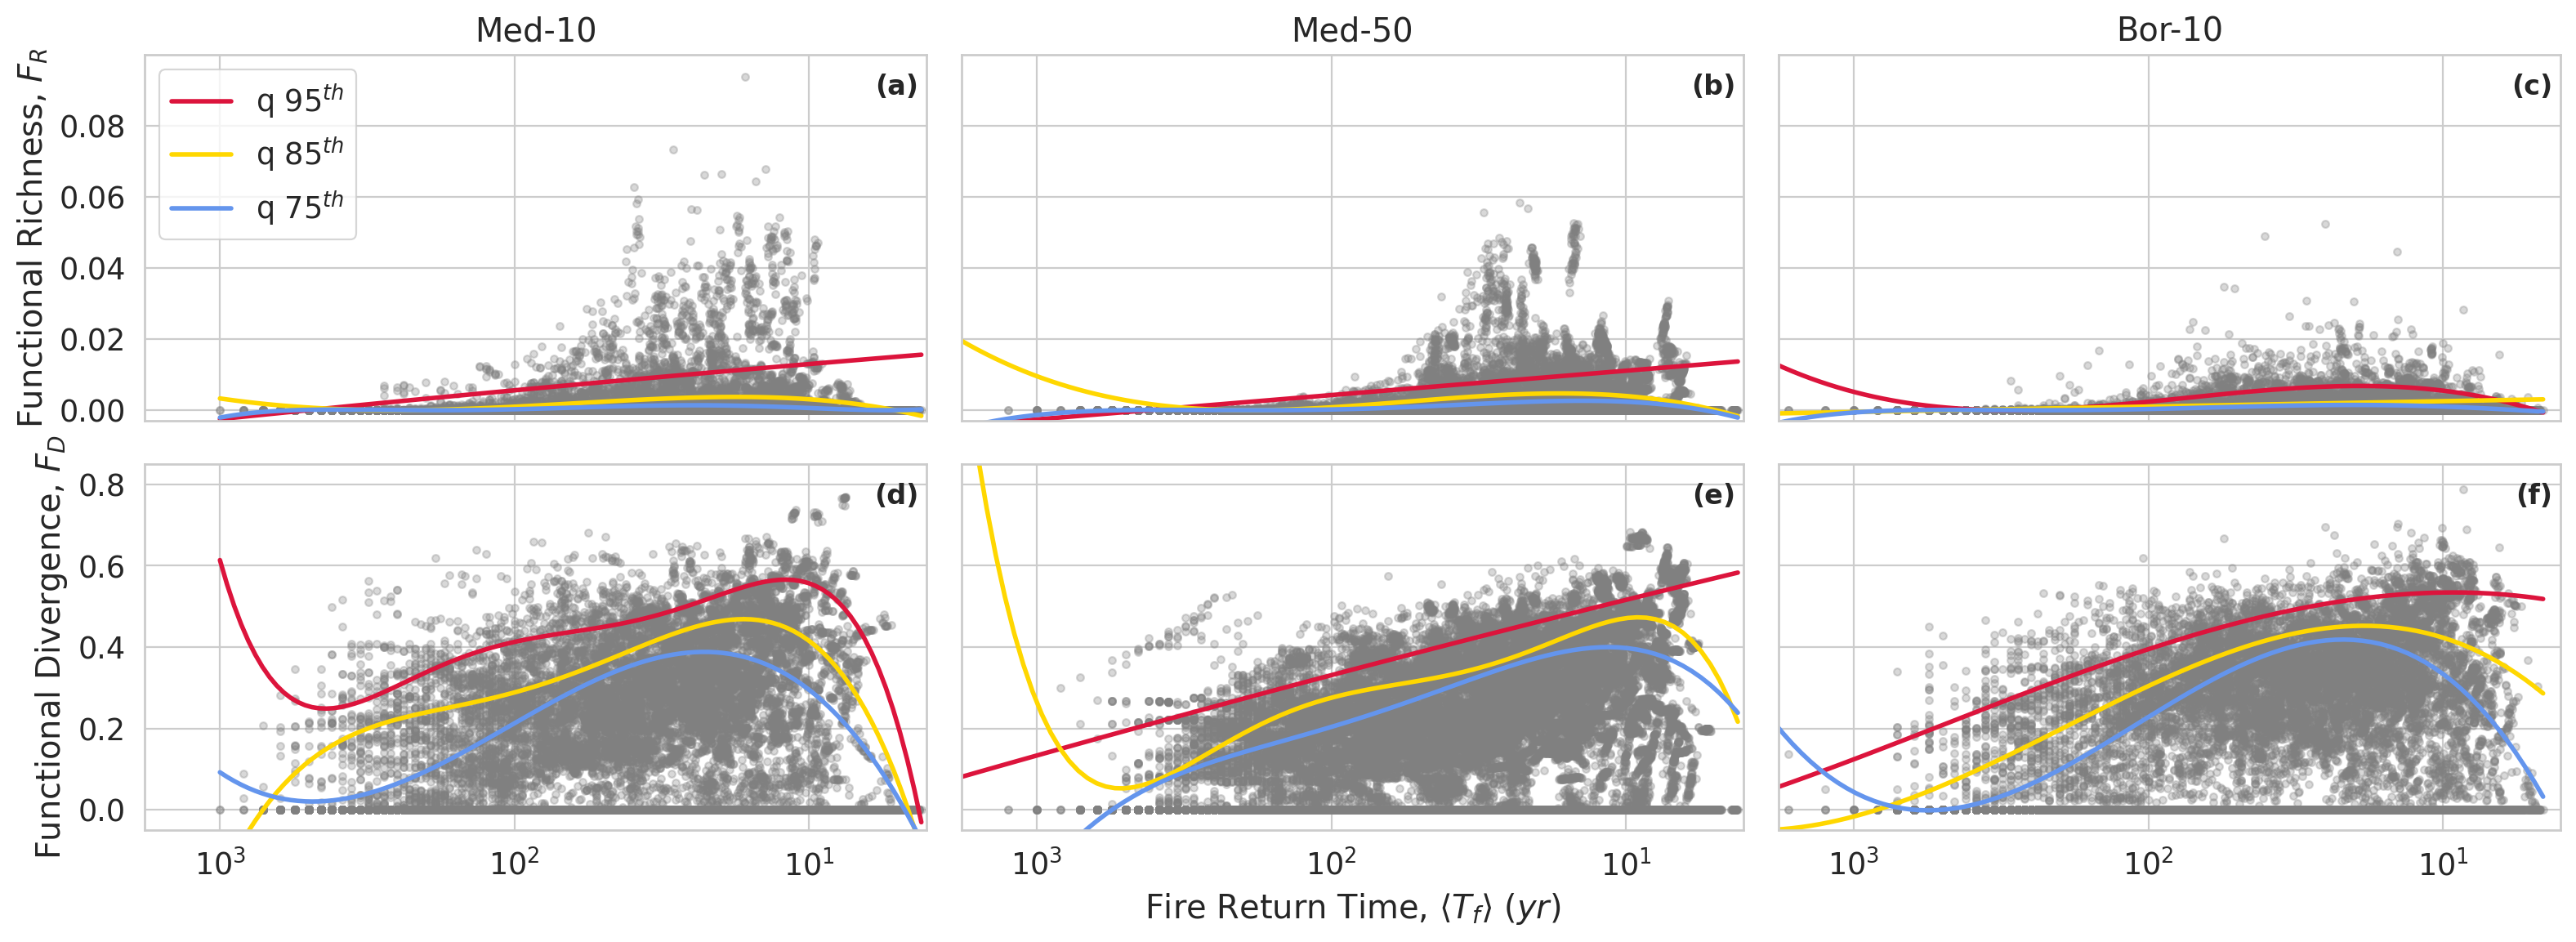

In [43]:
fig, ax2 = plt.subplots(2,3, figsize=(16,6), sharex=True, sharey='row', dpi=200)

n=10
i = 0
biome='med'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=True)

n=50
i = 1
biome='med'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=True)

n=10
i = 2
biome='bor'
plot_qreg_fdiv(df2, ax2, i, n, biome, quantiles, colorq, orientation='o', verbose=True)

ax2[1,1].set_xlabel(r"Fire Return Time, $\langle T_f \rangle$ ($yr$)")

for ax in ax2.flatten():
    ax.invert_xaxis()
    ax.set(xlim=(np.log10(frt_max),np.log10(frt_min)))
    # Set custom x-ticks at the positions of log10 values
    ticks = [1, 2, 3]
    ax.set_xticks(ticks)
    ax.set_xticklabels([fr'$10^{i}$' for i in ticks])

# Fix Y-ticks - Functional Richness
for ax in ax2[0]:
    ax.set_yticks(np.arange(0.0, 0.1, 0.02))
    ax.set_ylim([-0.003,0.1])

# Fix Y-ticks - Functional Divergence
for ax in ax2[1]:
    ax.set_yticks(np.arange(0.0, 0.9, 0.2))
    ax.set_ylim([-0.05,0.85])

ax2[0,0].set_title('Med-10')
ax2[0,1].set_title('Med-50')
ax2[0,2].set_title('Bor-10')

# Add identifying letters to each subplot, positioned at the top-right corner
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(ax2.flat):
    ax.text(0.99, 0.95, letters[i], transform=ax.transAxes, fontsize=12, fontweight='bold', 
            va='top', ha='right')

# ax2[0,-1].legend(bbox_to_anchor=(1.15, 1), loc="upper left", borderaxespad=0)
ax2[0,0].legend()
plt.tight_layout()

### Correlation of Biodiversity indicators

In [21]:
data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
data['eco-type'] = data['biome'] + data['N'].astype(str)
data.loc[data['eco-type']=='med10','eco-type'] = 'Med-10'
data.loc[data['eco-type']=='med50','eco-type'] = 'Med-50'
data.loc[data['eco-type']=='bor10','eco-type'] = 'Bor-10'
data

,Unnamed: 0,biome,N,ncom,init,frt,srichness,isimpson,frichness,fdivergence,eco-type
0,0,med,10,1,1,294.117645,2,1.988945,2.650758e-07,0.211732,Med-10
1,1,med,10,1,2,200.000000,2,1.965369,2.582685e-07,0.220906,Med-10
2,2,med,10,1,3,333.333344,2,1.995296,2.689386e-07,0.222537,Med-10
3,3,med,10,1,4,384.615387,2,1.998177,2.697325e-07,0.222559,Med-10
4,4,med,10,1,5,416.666656,2,1.998989,2.657836e-07,0.212782,Med-10
...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,med,50,1000,48,142.857147,3,1.198755,8.885737e-05,0.109243,Med-50
99996,99996,med,50,1000,49,172.413788,3,1.197153,1.111048e-04,0.115042,Med-50
99997,99997,med,50,1000,50,147.058823,3,1.203484,1.300694e-04,0.120101,Med-50
99998,99998,med,50,1000,51,142.857147,3,1.196005,7.591431e-05,0.106855,Med-50


In [31]:
def corrfunc(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    # sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = scs.pearsonr(x, y)
    
    # Set the regression line color dynamically based on correlation
    scatter_kws = kwds.get('scatter_kws', {'s': 10, 'color': 'pink'})
    line_color = cmap(norm(r))  # Match line color with heatmap color
    line_kws = kwds.get('line_kws', {'color': line_color, 'linewidth': 2})
    sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws=line_kws, ax=ax)
    
    # Add annotation in the upper-left corner
    ax.annotate(f"$r$={r:.2f}", xy=(0.08, 0.9), xycoords='axes fraction', color='black', size=12, ha='left', va='top')
    # ax.set_title(f"r={r:.2f}")
    
sns.set_theme(context="paper", style="white", font_scale=1.5, rc={"lines.linewidth": 2})

/tmp/ipykernel_3079742/1574649375.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


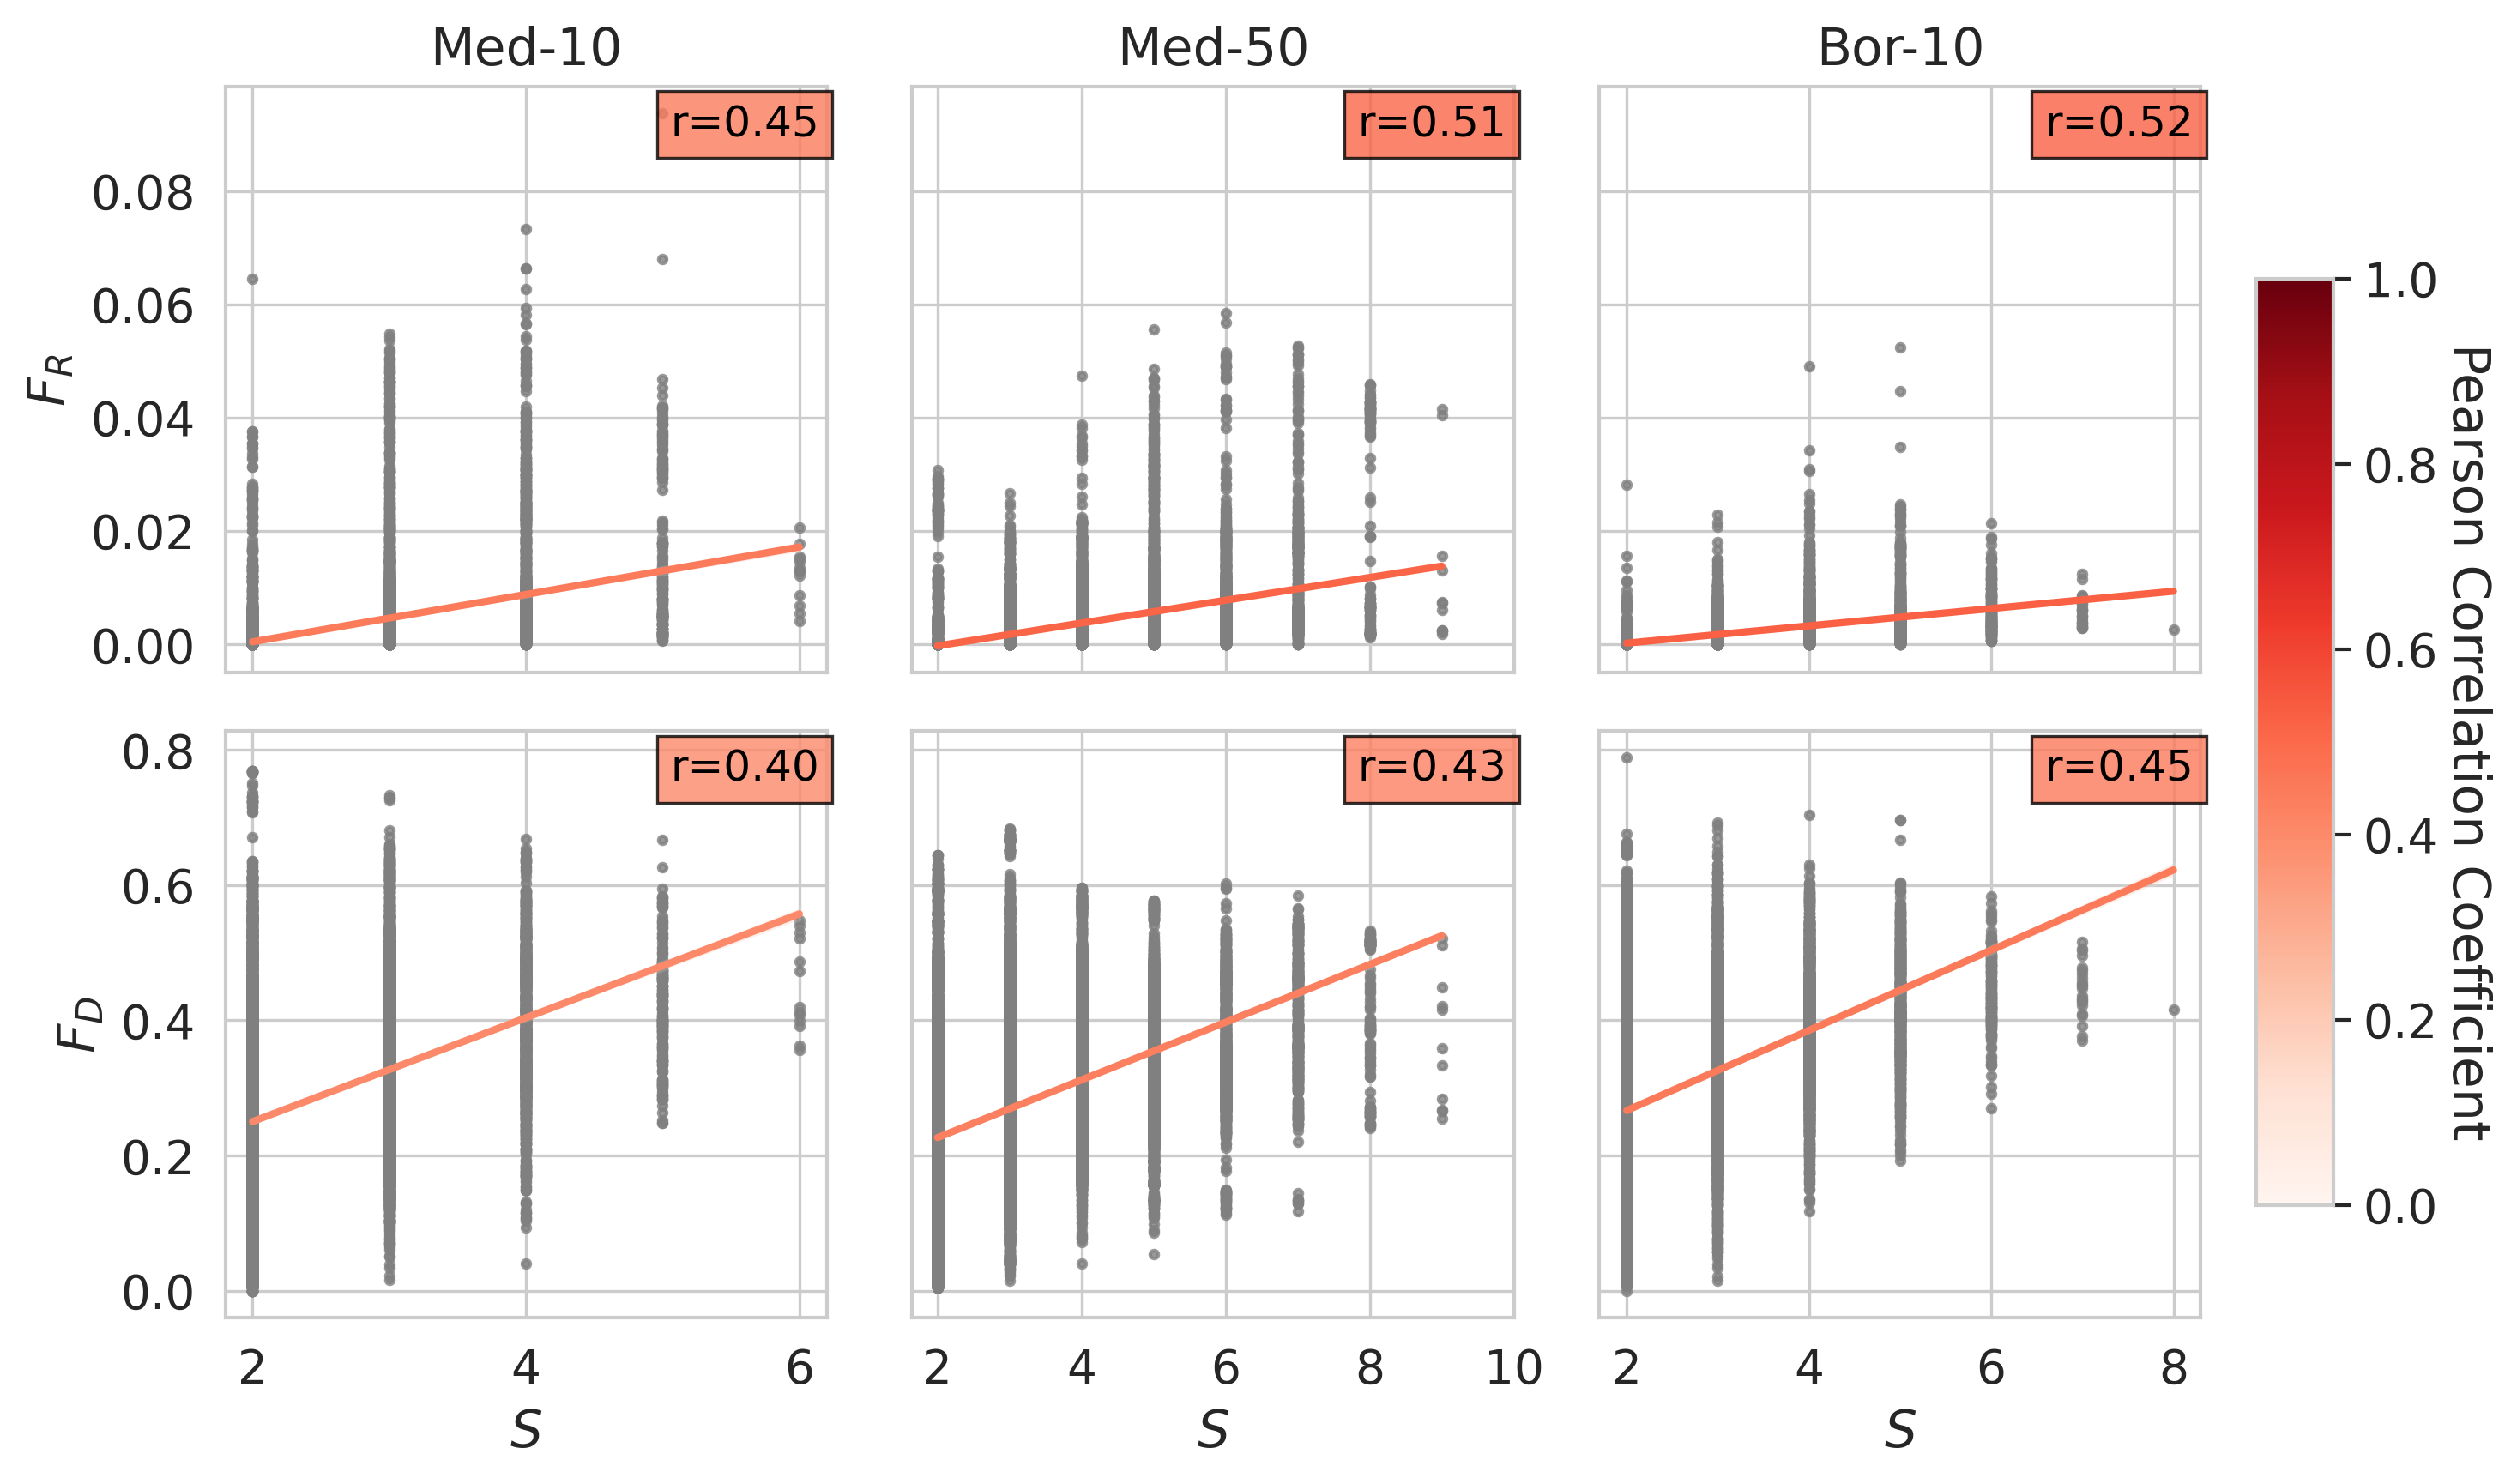

In [32]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.5, rc={"lines.linewidth": 2})

# Define the custom correlation function
def corrfunc(ax, x, y, cmap, norm, scatter_kws):
    r, _ = scs.pearsonr(x, y)
    
    # Set the regression line color dynamically based on correlation
    line_color = cmap(norm(r))  # Match line color with heatmap color
    sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws={'color': line_color, 'linewidth': 2}, ax=ax)
    
    # Add annotation in the upper-left corner
    bbox_props = dict(boxstyle="square", edgecolor="black", facecolor=line_color, alpha=0.8)
    ax.annotate(f"r={r:.2f}", xy=(0.74, 0.97), xycoords='axes fraction', color='black', size=12, ha='left', va='top', bbox=bbox_props)


# Set up color map and normalization
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

# Load data
data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})
df = data[(data['biome']=='med') & (data['N']==50)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d2 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})
df = data[(data['biome']=='bor') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d3 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})

# Variables to plot
x_vars = ["$S$"]
y_vars = ["$F_R$", "$F_D$"]

# Create the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharex='col', sharey='row', dpi=300)
scatter_kws = {'s': 5, 'color': 'grey'}

# Plot the first dataset
for i, y_var in enumerate(y_vars):
    ax = axes[i, 0]
    corrfunc(ax, d1["$S$"], d1[y_var], cmap_corr, norm_corr, scatter_kws)
axes[0,0].set_title("Med-10")

# Plot the second dataset
for i, y_var in enumerate(y_vars):
    ax = axes[i, 1]
    corrfunc(ax, d2["$S$"], d2[y_var], cmap_corr, norm_corr, scatter_kws)
    ax.set_xticks([2,4,6,8,10])
axes[0,1].set_title("Med-50")

for i, y_var in enumerate(y_vars):
    ax = axes[i, 2]
    corrfunc(ax, d3["$S$"], d3[y_var], cmap_corr, norm_corr, scatter_kws)
axes[0,2].set_title("Bor-10")

for ax in axes.flatten():
    ax.label_outer()

# Add a shared colorbar
cbar_ax = fig.add_axes([0.9, 0.2, 0.03, 0.6])  # [left, bottom, width, height]
sm = ScalarMappable(norm=norm_corr, cmap=cmap_corr)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Pearson Correlation Coefficient", rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar

In [25]:
def corrfunc(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    # sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = scs.pearsonr(x, y)
    
    # Set the regression line color dynamically based on correlation
    scatter_kws = kwds.get('scatter_kws', {'s': 10, 'color': 'pink'})
    line_color = cmap(norm(r))  # Match line color with heatmap color
    line_kws = kwds.get('line_kws', {'color': line_color, 'linewidth': 2})
    sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws=line_kws, ax=ax)
    
    # Add annotation in the upper-left corner
    bbox_props = dict(boxstyle="square", edgecolor="black", facecolor=line_color, alpha=0.8)
    ax.annotate(f"r={r:.2f}", xy=(0.72, 0.97), xycoords='axes fraction', color='black', size=12, ha='left', va='top', bbox=bbox_props)
    # ax.annotate(f"r={r:.2f}", xy=(0.08, 0989), xycoords='axes fraction', color='black', size=12, ha='left', va='top')
    # ax.set_title(f"r={r:.2f}")
    
# sns.set_theme(context="paper", style="white", font_scale=1.5, rc={"lines.linewidth": 2})

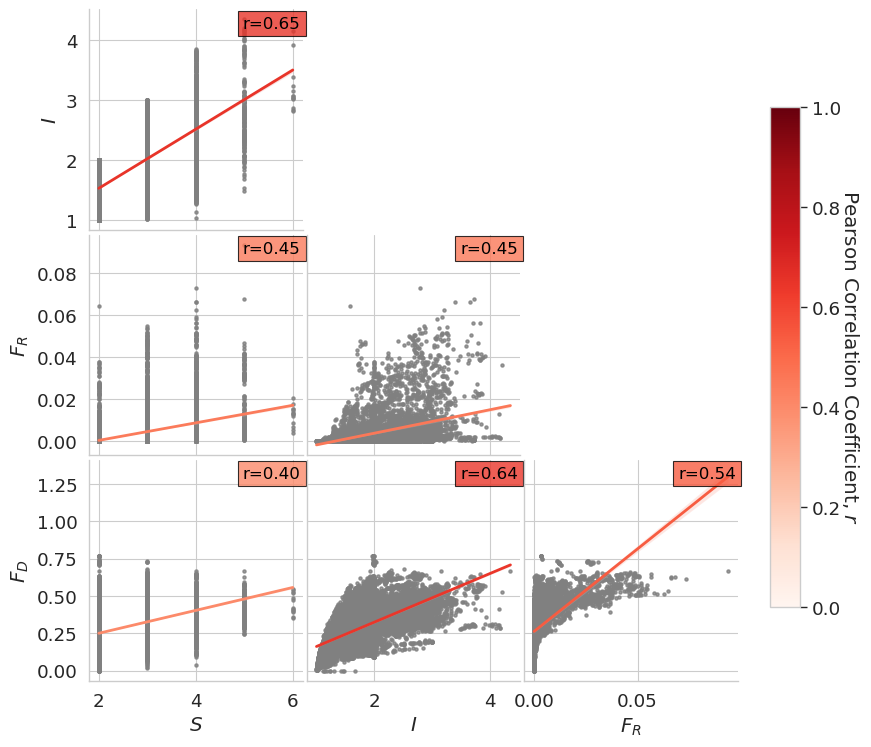

In [26]:
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})


g = sns.PairGrid(d1)
g.map_lower(corrfunc, cmap=cmap_corr, norm=norm_corr, scatter_kws={'s': 5, 'color': 'grey'})
# g.map_diag(sns.histplot, kde=False, element="step", color='grey')
# g.map_upper(corr_heat, cmap=cmap_corr, norm=norm_corr, grid=False)

# Remove diagonal and upper triangle by hiding the axes
for i in range(len(d1.columns)):
    for j in range(len(d1.columns)):
        if i <= j:  # Diagonal and upper triangle
            g.axes[i, j].set_visible(False)

# Add colorbar
fig = g.fig
cbar_ax = fig.add_axes([0.78, 0.15, 0.03, 0.5])  # [left, bottom, width, height] in figure coordinates
sm = ScalarMappable(norm=norm_corr, cmap=cmap_corr)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Pearson Correlation Coefficient, $r$", rotation=270, labelpad=15)

# g.figure.suptitle('Med-10')
g.fig.subplots_adjust(wspace=0.02, hspace=0.02)

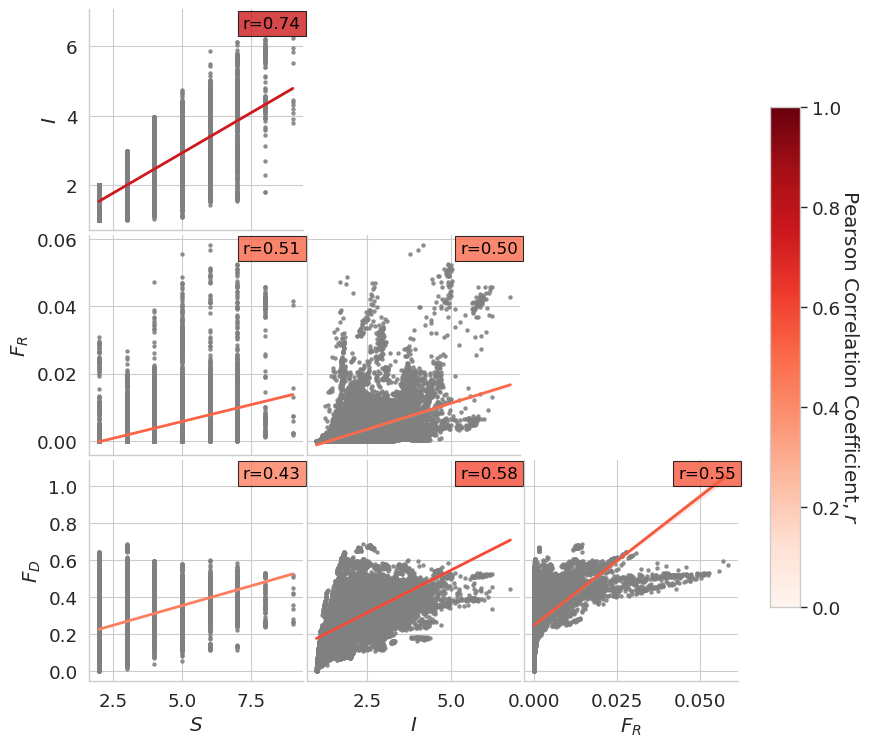

In [27]:
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='med') & (data['N']==50)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})

g = sns.PairGrid(d1)
g.map_lower(corrfunc, cmap=cmap_corr, norm=norm_corr, scatter_kws={'s': 5, 'color': 'grey'})
# g.map_diag(sns.histplot, kde=False, element="step", color='grey')
# g.map_upper(corr_heat, cmap=                _corr, norm=norm_corr, grid=False)

# Remove diagonal and upper triangle by hiding the axes
for i in range(len(d1.columns)):
    for j in range(len(d1.columns)):
        if i <= j:  # Diagonal and upper triangle
            g.axes[i, j].set_visible(False)

# Add colorbar
fig = g.fig
cbar_ax = fig.add_axes([0.78, 0.15, 0.03, 0.5])  # [left, bottom, width, height] in figure coordinates
sm = ScalarMappable(norm=norm_corr, cmap=cmap_corr)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Pearson Correlation Coefficient, $r$", rotation=270, labelpad=15)

# g.figure.suptitle('Bor-10')
g.fig.subplots_adjust(wspace=0.02, hspace=0.02)

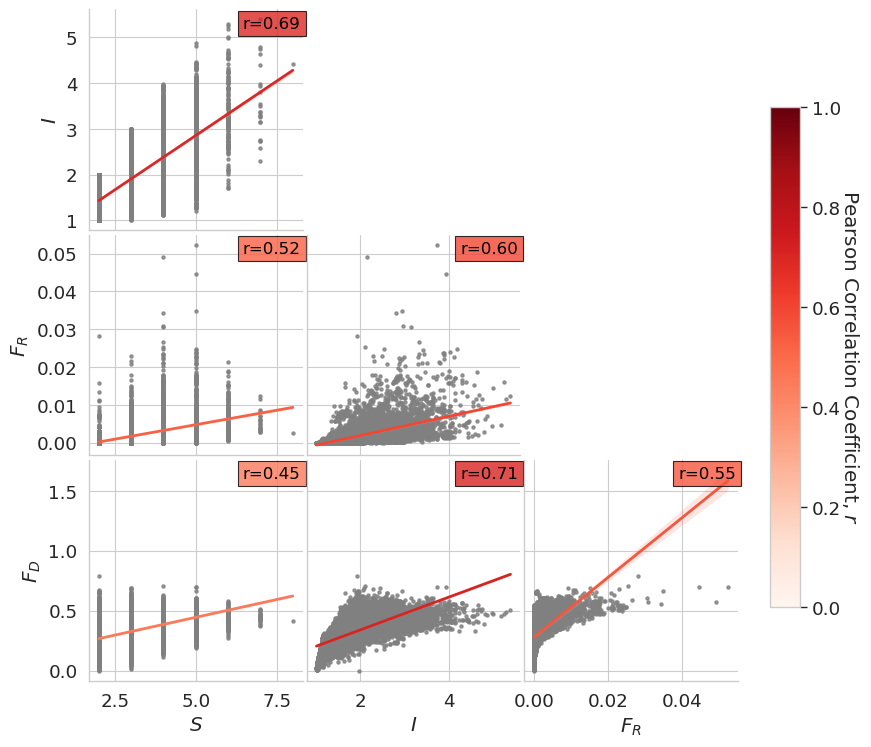

In [28]:
cmap_corr = mpl.colormaps['Reds']
norm_corr = mpl.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

data = pd.read_csv(os.path.join(fpath_out, 'coms-fire-bioindex-fd.csv'))
df = data[(data['biome']=='bor') & (data['N']==10)].set_index(['N', 'ncom', 'init']).drop(columns='Unnamed: 0')
d1 = df[(df['srichness']>1)].iloc[:,2:].rename(columns={'srichness':'$S$', 'isimpson':'$I$', 'frichness':'$F_R$', 'fdivergence':'$F_D$'})

g = sns.PairGrid(d1)
g.map_lower(corrfunc, cmap=cmap_corr, norm=norm_corr, scatter_kws={'s': 5, 'color': 'grey'})
# g.map_diag(sns.histplot, kde=False, element="step", color='grey')
# g.map_upper(corr_heat, cmap=cmap_corr, norm=norm_corr, grid=False)

# Remove diagonal and upper triangle by hiding the axes
for i in range(len(d1.columns)):
    for j in range(len(d1.columns)):
        if i <= j:  # Diagonal and upper triangle
            g.axes[i, j].set_visible(False)

# Add colorbar
fig = g.fig
cbar_ax = fig.add_axes([0.78, 0.15, 0.03, 0.5])  # [left, bottom, width, height] in figure coordinates
sm = ScalarMappable(norm=norm_corr, cmap=cmap_corr)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Pearson Correlation Coefficient, $r$", rotation=270, labelpad=15)

# g.figure.suptitle('Bor-10')
g.fig.subplots_adjust(wspace=0.02, hspace=0.02)